In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
qqq = 3

In [ ]:
# stdlib
import os
import shutil

# 3rd party
import ipyparallel as ipp
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# local
import kelp_analyze
import kelp_compute
import mms

In [ ]:
sp.init_printing()
%matplotlib inline

---

## User-function definitions

In [ ]:
def uniform_vsf(delta):
    return 1/(4*sp.pi)

In [ ]:
def linear_vsf(delta):
    return 2/sp.pi * (1-delta)

In [ ]:
# TODO: No upwelling light from bottom
# Also, spatially homogeneous BC
def prod_L(x, y, z, theta, phi, alpha, gamma):
    return (
        (
            (
                (2+sp.sin(2*sp.pi*x/alpha))
                *(2+sp.sin(2*sp.pi*y/alpha))
                *(sp.sin(sp.pi*z/gamma))
            ) + sp.exp(-z/gamma)
        )
        *(2+sp.sin(phi))
    )

In [ ]:
def uniform_L(x, y, z, theta, phi, alpha, gamma):
    return alpha

In [ ]:
def tanh_L(x, y, z, theta, phi, alpha, gamma):
    return alpha * sp.tanh(gamma-z)

In [ ]:
def tanh_b_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha * sp.tanh(gamma-b*z) * (1+z*sp.sin(x)*sp.sin(y))

In [ ]:
# TODO: Should be periodic on correct grid
def prod_a(x, y, z):
    return (2+sp.sin(2*sp.pi*x))*(2+sp.sin(2*sp.pi*y))*(1+sp.tanh(z-gamma))

In [ ]:
def uniform_a(x, y, z):
    return 0.2

### Decide here which functions to use.

In [ ]:
sol_func = tanh_b_L
abs_func = prod_a
vsf_func = linear_vsf

---

## Calculate source & BC

In [ ]:
b = sp.var('b')
params = sp.var('b, alpha, gamma')

source_expr = mms.calculate_source(sol_func, b, abs_func, vsf_func, params)
bc_expr = mms.calculate_bc(sol_func, params)

# Evaluate other expressions as well for consistency
sol_expr = sol_func(*mms.space, *mms.angle, *params)
abs_expr = abs_func(*mms.space)
vsf_expr = vsf_func(mms.delta)

## Specify parameter values

In [ ]:
alpha = 1
gamma = 1
b = 0.2
param_vals = {
    'alpha': alpha,
    'gamma': gamma,
    'b': b
}

# Domain size
rope_spacing = 1
zmax = 1

## Generate symbolic and numerical functions

In [ ]:
# Generate symbolic functions
source_sym = mms.symify(source_expr, *mms.space, *mms.angle, **param_vals)
abs_sym = mms.symify(abs_expr, *mms.space, **param_vals)
bc_sym = mms.symify(bc_expr, *mms.angle, **param_vals)
vsf_sym = mms.symify(vsf_expr, mms.delta, **param_vals)
sol_sym = mms.symify(sol_expr, *mms.space, *mms.angle, **param_vals)

# Generate numerical functions
abs_func_N = kelp_compute.sym_to_num(abs_sym, *mms.space)
source_func_N = kelp_compute.sym_to_num(source_sym, *mms.space, *mms.angle)
bc_func_N = kelp_compute.sym_to_num(bc_sym, *mms.angle)
vsf_func_N = kelp_compute.sym_to_num(vsf_sym, mms.delta)
sol_func_N = kelp_compute.sym_to_num(sol_sym, *mms.space, *mms.angle)

## Problem Summary

In [ ]:
print("Solution")
mms.display_eq('L', sol_expr)
print()

print("Absorption Coefficient")
mms.display_eq('a', abs_expr)
print()

print("VSF")
mms.display_eq('beta', vsf_expr)

print("Boundary Condition")
mms.display_eq('L_0', bc_expr)
print()

print("Source")
mms.display_eq('sigma', source_expr)
print()

## Check solution constraints

- Everything is periodic in x, y
- Absorption coefficient is positive
- Boundary condition depends only on angle
- No upwelling light from below

## Check source term

Source term seems too high, so try substituting parameters,
then plugging in analytical solution.

The result should be 0.

In [ ]:
diff = mms.check_sol(sol_sym, b, abs_sym, vsf_sym, source_sym)
diff

In [ ]:
num_diff = sp.lambdify(
    (*mms.space, *mms.angle),
    diff,
    modules=("numpy",)
)

In [ ]:
# Check numerical max on grid in case of numerical error in above expression
np.max(num_diff(*mms.gen_grid(10, 10, 10, 1, 1)))

## Code Verification Study

In [ ]:
#remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()
dv = ipc.direct_view()
print(ipc.ids)

In [93]:
# Set parameters
study_name = 'verify_test'
kelp_dist='top-heavy'

ns_max = 12
nz_max = 12
ntheta_max = 12
nphi_max = 12

ns_list = range(4, ns_max+1, 4)
nz_list = range(4, nz_max+1, 4)
ntheta_list = range(4, ntheta_max+1, 4)
nphi_list = range(4, nphi_max+1, 4)

# ns_list = [10]
# nz_list = [10]
# ntheta_list = [10]
# nphi_list = [10]

#base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

# TODO: Don't actually delete results
shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.fd_verify_compute(
    study_name, 
    ns_list, nz_list, ntheta_list, nphi_list, 
    rope_spacing, zmax, b, 
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr, 
    param_vals, base_dir=base_dir)

/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@oliver-arch')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


Creating new study directory.
Running grid (12,12,12,12)
Running grid ( 4,12,12,12)
Running grid ( 8,12,12,12)
Running grid (12, 4,12,12)
Running grid (12, 8,12,12)
Running grid (12,12, 4,12)
Running grid (12,12, 8,12)
Running grid (12,12,12, 4)
Running grid (12,12,12, 8)
Reading existing runs.
Finished reading existing runs.
Calling solve_rte_with_callbacks(12, 12, 12, 12, 1, 1, 0.2, alpha*(z*sin(x)*sin(y) + 1)*tanh(-b*z + gamma), (sin(2*pi*x) + 2)*(sin(2*pi*y) + 2)*(tanh(-gamma + z) + 1), alpha*z*sin(phi)*sin(theta)*sin(x)*cos(y)*tanh(-b*z + gamma) + alpha*z*sin(phi)*sin(y)*cos(theta)*cos(x)*tanh(-b*z + gamma) + alpha*(b + (sin(2*pi*x) + 2)*(sin(2*pi*y) + 2)*(tanh(-gamma + z) + 1))*(z*sin(x)*sin(y) + 1)*tanh(-b*z + gamma) - b*(2*alpha*(pi*sin(phi)*sin(theta)/2 + 2*pi)*(z*sin(x)*sin(y) + 1)*tanh(-b*z + gamma)/pi - alpha*(z*sin(x)*sin(y) + 1)*sin(phi)*sin(theta)*tanh(-b*z + gamma) + 4*alpha*(z*sin(x)*sin(y) + 1)*tanh(-b*z + gamma)) + (-alpha*b*(z*sin(x)*sin(y) + 1)*(-tanh(-b*z + gamma)

## Analyze convergece

In [61]:
import sqlite3

In [97]:
study_dir = os.path.join(base_dir, study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

In [99]:
len(kelp_analyze.query_results(conn, study_name, ns=8, nz=12, ntheta=12, nphi=12))

In [111]:
from scipy.optimize import minimize

In [108]:
def lin_fit(x, y, x0, x1):
    x_arr = np.array(x)
    y_arr = np.array(y)
    which_inds = np.logical_and(
        x_arr>=x0,
        x_arr<=x1
    )
    x_fit = x_arr[which_inds]
    y_fit = y_arr[which_inds]
    
    def resid(args):
        m, b = args
        res = np.sum((m*x_fit + b - y_fit) ** 2)
        return res
    
    m0 = 1
    b0 = 0
    res = minimize(resid, (m0, b0))
    m, b = res.x
    
    return m, b

In [109]:
def plot_lin_fit(x, y, x0, x1, xlabel='x', ylabel='y'):
    xmin = np.min(x)
    ymin = np.min(y)
    xmax = np.max(x)
    ymax = np.max(y)
    
    plt.plot(x, y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.vlines((x0, x1), ymin, ymax, colors='k', linestyles='dashed')
    
    m, b = lin_fit(x, y, x0, x1)
    label = 'm={:.2f}, b={:.2f}'.format(m, b)
    plt.plot([xmin, xmax], [m*xmin + b, m*xmax + b], '--')
    plt.title(label)
    plt.show()

ns


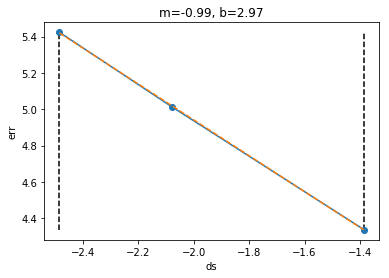

nz


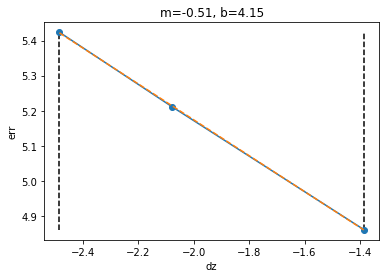

ntheta


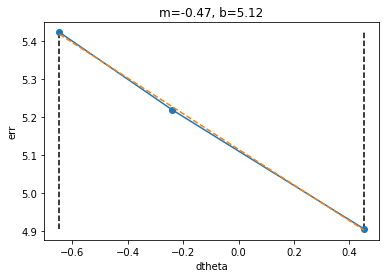

nphi


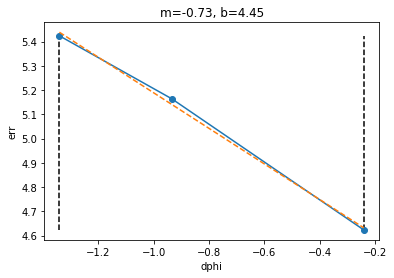

In [121]:
norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)

# ns
print("ns")
err_dict = {}
for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns, nz=nz_max, ntheta=ntheta_max, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:].data
    true_rad = results_list[0]['true_rad'][:].data
    
    err = norm(rad - true_rad)
    err_dict[ns] = err

res_arr = rope_spacing / np.array(ns_list)
err_arr = np.array([err_dict[ns] for ns in ns_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='ds', ylabel='err'
)

# nz
print("nz")
err_dict = {}
for nz in nz_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz, ntheta=ntheta_max, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:].data
    true_rad = results_list[0]['true_rad'][:].data
    
    err = norm(rad - true_rad)
    err_dict[nz] = err

res_arr = zmax / np.array(nz_list)
err_arr = np.array([err_dict[nz] for nz in nz_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='dz', ylabel='err'
)

# ntheta
print("ntheta")
err_dict = {}
for ntheta in ntheta_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz_max, ntheta=ntheta, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:].data
    true_rad = results_list[0]['true_rad'][:].data
    
    err = norm(rad - true_rad)
    err_dict[ntheta] = err

res_arr = 2*np.pi / np.array(ntheta_list)
err_arr = np.array([err_dict[ntheta] for ntheta in ntheta_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='dtheta', ylabel='err'
)

# nphi
print("nphi")
err_dict = {}
for nphi in nphi_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz_max, ntheta=ntheta_max, nphi=nphi
    )
    
    rad = results_list[0]['rad'][:].data
    true_rad = results_list[0]['true_rad'][:].data
    
    err = norm(rad - true_rad)
    err_dict[nphi] = err

res_arr = np.pi / np.array(nphi_list)
err_arr = np.array([err_dict[nphi] for nphi in nphi_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='dphi', ylabel='err'
)

In [ ]:
1/0

# Single-run

### Compute

In [ ]:
# Grid options
ns = 16
nz = 16
na = 10
nomega = na*(na-2) + 2

# Domain size
rope_spacing = 1
zmax = 1

# Solver options
lis_opts = "-i gmres -restart 100 -tol 1e-3"

# Set num_scatters
num_scatters_list = range(5)
max_num_scatters = max(num_scatters_list)

# Norm for error calculations
norm = lambda arr: np.linalg.norm(np.ravel(arr), ord=2)/np.size(arr)

# Numerical function for solution expansion
sol_expansion_N = mms.gen_series_N(sol_expr, max_num_scatters, **param_vals)

asymptotic_sol_dict = {}
sol_expansion_dict = {}
asymptotic_err_dict = {}
sol_expansion_err_dict = {}

for num_scatters in num_scatters_list:
    print("n={}".format(num_scatters))
    # Calculate asymptotic solution
    _, asymptotic_results = kelp_compute.solve_rte_with_callbacks_full(
        ns, nz, na,
        rope_spacing, zmax,
        b, abs_expr, source_expr, source_expansion_N, bc_expr, vsf_expr,
        param_dict, num_scatters=num_scatters, fd_flag=False, lis_opts=lis_opts
    )

    # Extract numerical solutions
    asymptotic_sol = asymptotic_results['rad']
    
    # Store results
    asymptotic_sol_dict[num_scatters] = asymptotic_sol
    
    # Evaluate true solution
    x, y, z, theta, phi = mms.gen_grid(ns, nz, na, rope_spacing, zmax)
    true_sol = sol_func_N(x, y, z, theta, phi)
    
    # Evaluate series expansion
    sol_expansion = np.zeros_like(asymptotic_sol)
    for n in range(num_scatters+1):
        sol_expansion += b**n * sol_expansion_N(x, y, z, theta, phi, n) 
    sol_expansion_dict[num_scatters] = sol_expansion
    
    # Calculate errors
    asymptotic_err = norm(asymptotic_sol-true_sol)
    asymptotic_err_dict[num_scatters] = asymptotic_err
    
    sol_expansion_err = norm(sol_expansion - true_sol)
    sol_expansion_err_dict[num_scatters] = sol_expansion_err

# Evaluate true solution on same grid
true_sol = sol_func_N(x, y, z, theta, phi)

In [ ]:
# Calculate finite difference solution
_, fd_results = kelp_compute.solve_rte_with_callbacks_full(
    ns, nz, na,
    rope_spacing, zmax,
    b, abs_sym, source_sym, source_expansion_N, bc_sym, vsf_sym,
    num_scatters=0, fd_flag=True, lis_opts=lis_opts
)

fd_sol = fd_results['rad']

fd_err = norm(fd_sol-true_sol)

### Plot

In [ ]:
# Pick one angle to evaluate symbolically and plot
l = 0
m = int(np.floor(na/4))

p = mms.p_hat(l, m, na)
th = theta[0,0,0,p]
ph = phi[0,0,0,p]

In [ ]:
plot_inds = np.zeros_like(true_sol, dtype=bool)
plot_inds[0,0,:,p] = True

plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

# Plot true solution
ax1.plot(z[plot_inds], true_sol[plot_inds], 'C0o-', label='true')

# Plot FD solution
ax1.plot(
    z[plot_inds],
    fd_sol[plot_inds], 
    'C1o-',
    label='FD'
)

# Plot FD error
ax2.plot(
    z[plot_inds], 
    -true_sol[plot_inds]+fd_sol[plot_inds], 
    'C1o-',
    label='FD'
)

ax3.plot(
    z[plot_inds], 
    np.abs(-true_sol[plot_inds]+fd_sol[plot_inds]), 
    'C1o-',
    label='FD'
)

for num_scatters in num_scatters_list:
    ax1.plot(
        z[plot_inds], 
        sol_expansion_dict[num_scatters][plot_inds], 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    ax1.plot(
        z[plot_inds], 
        asymptotic_sol_dict[num_scatters][plot_inds], 
        'C{}o--'.format(num_scatters+2)
    )
    
    # Plot true expansion error
    ax2.plot(
        z[plot_inds], 
        -true_sol[plot_inds]+sol_expansion_dict[num_scatters][plot_inds], 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    ax3.plot(
        z[plot_inds], 
        np.abs(-true_sol[plot_inds]+sol_expansion_dict[num_scatters][plot_inds]), 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    
    # Plot numerical asymptotics error
    ax2.plot(
        z[plot_inds], 
        -true_sol[plot_inds]+asymptotic_sol_dict[num_scatters][plot_inds], 
        'C{}o--'.format(num_scatters+2)
    )
    ax3.plot(
        z[plot_inds], 
        np.abs(-true_sol[plot_inds]+asymptotic_sol_dict[num_scatters][plot_inds]), 
        'C{}o--'.format(num_scatters+2)
    )
    
    
ax1.set_xlabel('z')
ax1.set_ylabel('rad')
ax1.legend()

ax2.set_xlabel('z')
ax2.set_ylabel('stripe diff')
ax2.set_yscale('linear')
ax2.legend()

ax3.set_xlabel('z')
ax3.set_ylabel('stripe err')
ax3.set_yscale('log')
ax3.legend()

# FD Error
ax4.hlines(fd_err, xmin=0, xmax=max_num_scatters, label='FD')

# Asymptotics error
ax4.plot(
    num_scatters_list, 
    [asymptotic_err_dict[n] for n in num_scatters_list],
    'o-',
    label='asym. err.'
)
# Expansion error
ax4.plot(
    num_scatters_list, 
    [sol_expansion_err_dict[n] for n in num_scatters_list],
    'o-',
    label='series err.'
)
ax4.set_xlabel('n')
ax4.set_ylabel('avg. tot. err.')
ax4.set_yscale('linear')
ax4.legend()